In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le fichier .npy
scatters = np.load("save/order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")

# Afficher le contenu
print(scatters.shape)

(6591, 12)


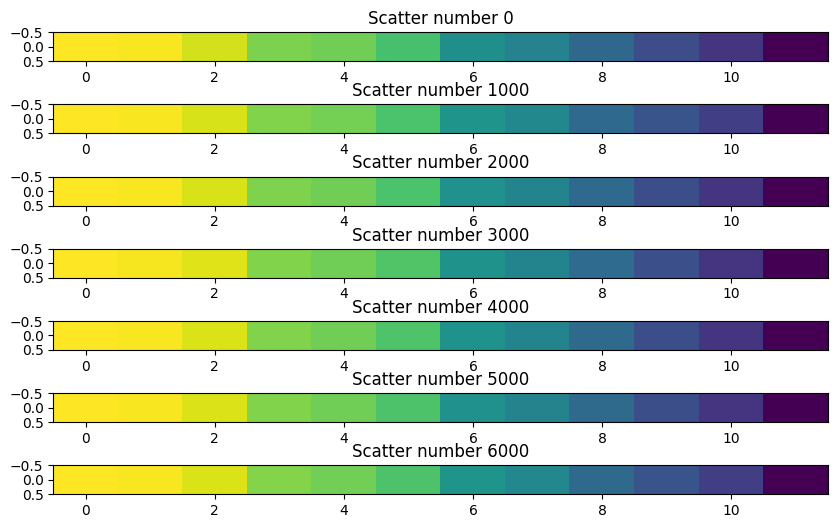

In [2]:
nb_mol = scatters.shape[0]
nb_viz = nb_mol//1000 + 1

# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(10, 6))
for j in range(nb_mol):
    if j%1000 == 0:
        current_scatter = scatters[j]
        ind_subplot = j//1000
        plt.subplot(nb_viz, 1, ind_subplot + 1)
        plt.imshow(np.log(np.expand_dims(current_scatter, axis=0)), cmap='viridis', aspect='auto', vmin=np.log(np.min(current_scatter)), vmax=np.log(np.max(current_scatter)))
        plt.title(f'Scatter number {j}')
plt.subplots_adjust(hspace=1.5)
plt.show()
# %%%%% end TODO %%%%%

In [3]:
centered_scatters = scatters - scatters.mean(0)

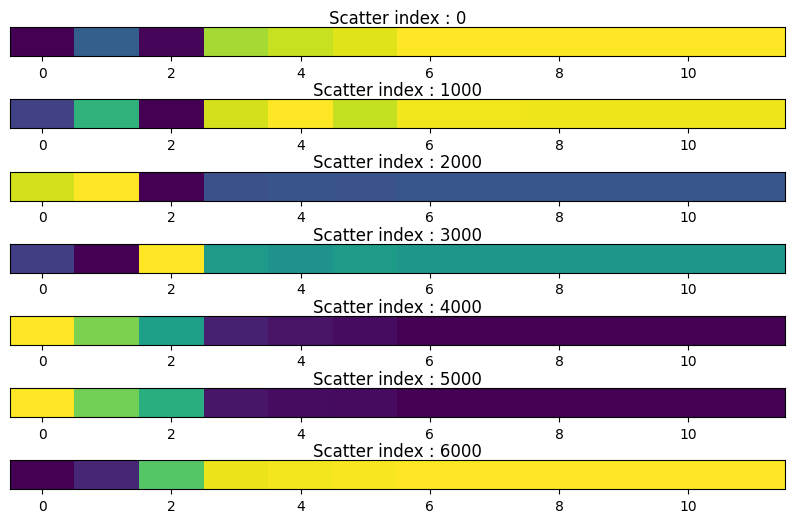

In [4]:
nb_mol = centered_scatters.shape[0]
nb_viz = nb_mol//1000 + 1

# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(10, 6))
for j in range(nb_mol):
    if j%1000 == 0:
        current_scatter = centered_scatters[j]
        ind_subplot = j//1000
        plt.subplot(nb_viz, 1, ind_subplot + 1)
        plt.imshow(np.expand_dims(current_scatter, axis=0), cmap='viridis', aspect='auto', vmin=np.min(current_scatter), vmax=np.max(current_scatter))
        plt.axis()
        plt.title(f'Scatter index : {j}', pad = 0)
        plt.ylabel("")
        plt.yticks([])
plt.subplots_adjust(hspace=1.5)
plt.show()
# %%%%% end TODO %%%%%

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le fichier .npy
scatters = np.load("save/orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")

# Afficher le contenu
print(scatters.shape)

(6591, 108)


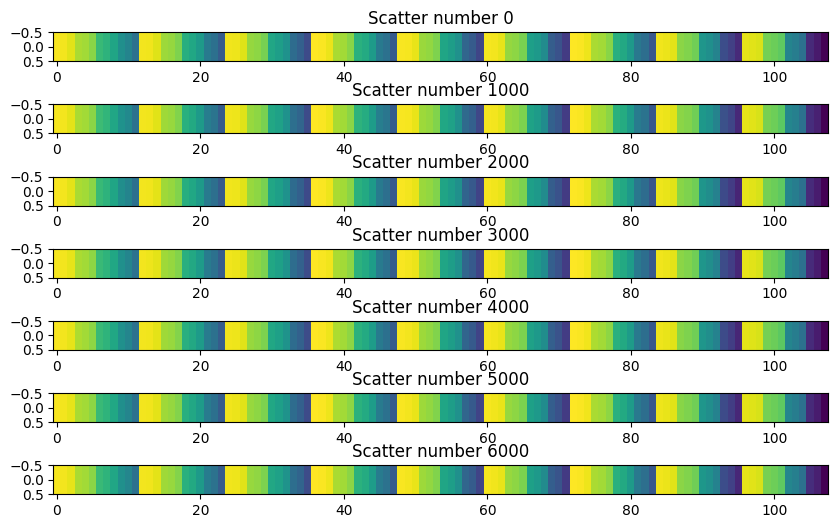

In [21]:
nb_mol = scatters.shape[0]
nb_viz = nb_mol//1000 + 1

# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(10, 6))
for j in range(nb_mol):
    if j%1000 == 0:
        current_scatter = scatters[j]
        ind_subplot = j//1000
        plt.subplot(nb_viz, 1, ind_subplot + 1)
        plt.imshow(np.log(np.expand_dims(current_scatter, axis=0)), cmap='viridis', aspect='auto', vmin=np.log(np.min(current_scatter)), vmax=np.log(np.max(current_scatter)))
        plt.title(f'Scatter number {j}')
plt.subplots_adjust(hspace=1.5)
plt.show()
# %%%%% end TODO %%%%%

In [22]:
centered_scatters = scatters - scatters.mean(0)

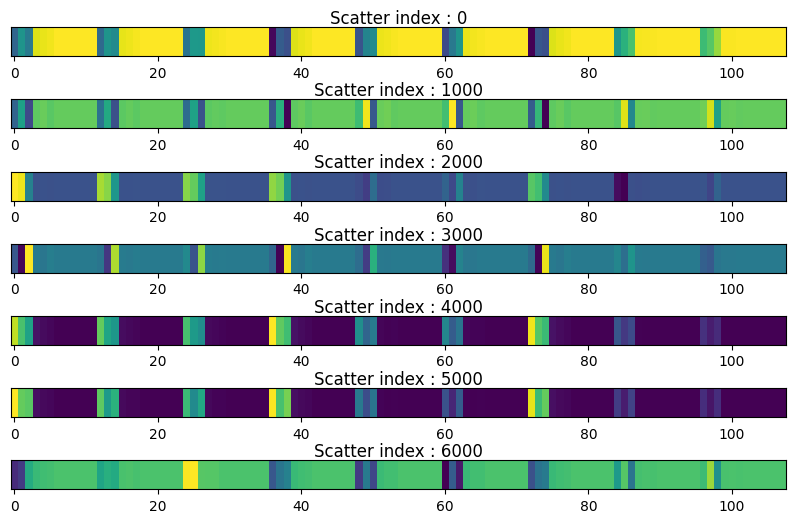

In [23]:
nb_mol = centered_scatters.shape[0]
nb_viz = nb_mol//1000 + 1

# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(10, 6))
for j in range(nb_mol):
    if j%1000 == 0:
        current_scatter = centered_scatters[j]
        ind_subplot = j//1000
        plt.subplot(nb_viz, 1, ind_subplot + 1)
        plt.imshow(np.expand_dims(current_scatter, axis=0), cmap='viridis', aspect='auto', vmin=np.min(current_scatter), vmax=np.max(current_scatter))
        plt.axis()
        plt.title(f'Scatter index : {j}', pad = 0)
        plt.ylabel("")
        plt.yticks([])
plt.subplots_adjust(hspace=1.5)
plt.show()
# %%%%% end TODO %%%%%

### **Test de régression avec les scatterings centrés**

In [5]:
import numpy as np
import torch
import time
import os

from sklearn import (linear_model, model_selection, preprocessing,
                     pipeline)
from scipy.spatial.distance import pdist

from kymatio.torch import HarmonicScattering3D

from kymatio.scattering3d.backend.torch_backend \
    import TorchBackend3D

from kymatio.scattering3d.utils \
    import generate_weighted_sum_of_gaussians

from kymatio.datasets import fetch_qm7
from kymatio.caching import get_cache_dir

import random

import pandas as pd
from ase.io import read

from xgboost import XGBRegressor

In [6]:
# J = 2
# L = 3
J = 1
L = 2
integral_powers = [0.5, 1.0, 2.0, 3.0]

In [9]:
#M, N, O = 192, 128, 96
M, N, O = 32, 32, 32

grid = np.mgrid[-M//2:-M//2+M, -N//2:-N//2+N, -O//2:-O//2+O]
grid = np.fft.ifftshift(grid)

In [12]:
# Charger les données
train_energies = pd.read_csv('../data/energies/train.csv')
molecule_ids = train_energies['id'].values
energies = train_energies['energy'].values

# Initialiser les listes pour stocker toutes les positions et charges
all_positions = []
all_charges = []

# Lire tous les fichiers .xyz avec ASE
for mol_id in molecule_ids:
    xyz_path = f'../data/atoms/train/id_{mol_id}.xyz'
    atoms = read(xyz_path)
    
    # Obtenir les positions et numéros atomiques
    coords = atoms.get_positions()
    atomic_numbers = atoms.get_atomic_numbers()
    
    # Padding pour avoir une taille fixe
    max_atoms = 23  # Ajuster selon le nombre maximum d'atomes
    padded_coords = np.zeros((max_atoms, 3))
    padded_charges = np.zeros(max_atoms)
    
    n_atoms = len(coords)
    padded_coords[:n_atoms] = coords
    padded_charges[:n_atoms] = atomic_numbers
    
    all_positions.append(padded_coords)
    all_charges.append(padded_charges)

# Convertir en arrays numpy
pos = np.array(all_positions)
full_charges = np.array(all_charges)
target = energies

# Le reste du code reste identique à partir de la définition de n_molecules
n_molecules = len(pos)

# ...existing code...

In [13]:
overlapping_precision = 1e-1
sigma = 2.0
min_dist = np.inf

for i in range(n_molecules):
    n_atoms = np.sum(full_charges[i] != 0)
    pos_i = pos[i, :n_atoms, :]
    min_dist = min(min_dist, pdist(pos_i).min())

delta = sigma * np.sqrt(-8 * np.log(overlapping_precision))
pos = pos * delta / min_dist

In [14]:
scattering = HarmonicScattering3D(J=J, shape=(M, N, O),
                                  L=L, sigma_0=sigma,
                                  integral_powers=integral_powers)

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
scattering.to(device)

HarmonicScattering3D()

In [16]:
# n_folds = 5
n_folds = 3

P = np.random.permutation(n_molecules).reshape((n_folds, -1))

cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

In [17]:
batch_size = 8
#batch_size = 16
n_batches = int(np.ceil(n_molecules / batch_size))

In [17]:
order_0 = np.load("save/order_0_traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")
orders_1_and_2 = np.load("save/orders_1_and_2traindataset_L_2_J_1_sigma_2.0_MNO_(32, 32, 32)_powers_[0.5, 1.0, 2.0, 3.0].npy")

In [18]:
centered_orders_0 = order_0 - order_0.mean(0)
centered_orders_1_and_2 = orders_1_and_2 - orders_1_and_2.mean(0)

In [19]:
scattering_coef = np.concatenate([centered_orders_0, centered_orders_1_and_2], axis=1)

In [ ]:
alphas = 10.0 ** (-np.arange(1, 10))
for i, alpha in enumerate(alphas):
    scaler = preprocessing.StandardScaler()
    ridge = linear_model.Ridge(alpha=alpha)

    regressor = pipeline.make_pipeline(scaler, ridge)

    target_prediction = model_selection.cross_val_predict(regressor,
            X=scattering_coef, y=target, cv=cross_val_folds)

    MAE = np.mean(np.abs(target_prediction - target))
    RMSE = np.sqrt(np.mean((target_prediction - target) ** 2))

    print('Ridge regression, alpha: {}, MAE: {}, RMSE: {}'.format(
        alpha, MAE, RMSE))

Ridge regression, alpha: 0.1, MAE: 5.513215425131381, RMSE: 7.009911251762491
Ridge regression, alpha: 0.01, MAE: 5.332145082009417, RMSE: 6.879018128364082


/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.26258e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.61498e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.75646e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge regression, alpha: 0.001, MAE: 5.267081167184161, RMSE: 6.816687489886938
Ridge regression, alpha: 0.0001, MAE: 5.255969164199653, RMSE: 6.784238411573692
Ridge regression, alpha: 1e-05, MAE: 5.255904148098153, RMSE: 6.76009022337208
Ridge regression, alpha: 1e-06, MAE: 5.243404513313816, RMSE: 6.7421159659433725
Ridge regression, alpha: 1e-07, MAE: 5.2296835936570005, RMSE: 6.735413837030329
Ridge regression, alpha: 1e-08, MAE: 5.2299823382510136, RMSE: 6.741744321343204
Ridge regression, alpha: 1e-09, MAE: 5.232916363553908, RMSE: 6.748056981914755


In [41]:
# Charger et préparer les données de test
test_positions = []
test_charges = []

# Lister tous les fichiers .xyz dans le dossier test
test_files = sorted(os.listdir('../data/atoms/test'))
test_ids = [int(f.split('_')[1].split('.')[0]) for f in test_files]  # Extraire les IDs

# Lire tous les fichiers .xyz de test
for xyz_file in test_files:
    xyz_path = os.path.join('../data/atoms/test', xyz_file)
    atoms = read(xyz_path)
    
    # Obtenir les positions et numéros atomiques
    coords = atoms.get_positions()
    atomic_numbers = atoms.get_atomic_numbers()
    
    # Padding pour avoir une taille fixe
    padded_coords = np.zeros((max_atoms, 3))
    padded_charges = np.zeros(max_atoms)
    
    n_atoms = len(coords)
    padded_coords[:n_atoms] = coords
    padded_charges[:n_atoms] = atomic_numbers
    
    test_positions.append(padded_coords)
    test_charges.append(padded_charges)

# Convertir en arrays numpy
test_pos = np.array(test_positions)
test_full_charges = np.array(test_charges)
n_test_molecules = len(test_pos)

# Appliquer la même normalisation que pour les données d'entraînement
test_pos = test_pos * delta / min_dist

# Calculer les coefficients de scattering pour les données de test
test_order_0 = []
test_orders_1_2 = []

for i in range(0, n_test_molecules, batch_size):
    end = min(i + batch_size, n_test_molecules)
    pos_batch = test_pos[i:end]
    charges_batch = test_full_charges[i:end]
    
    # Calculer les valence charges
    mask = charges_batch <= 2
    val_batch = charges_batch * mask
    mask = np.logical_and(charges_batch > 2, charges_batch <= 10)
    val_batch += (charges_batch - 2) * mask
    mask = np.logical_and(charges_batch > 10, charges_batch <= 18)
    val_batch += (charges_batch - 10) * mask
    
    # Calculer les descripteurs comme pour l'entraînement
    full_density = generate_weighted_sum_of_gaussians(grid, pos_batch, charges_batch, sigma)
    full_density = torch.from_numpy(full_density).to(device).float()
    
    val_density = generate_weighted_sum_of_gaussians(grid, pos_batch, val_batch, sigma)
    val_density = torch.from_numpy(val_density).to(device).float()
    
    core_density = full_density - val_density
    
    # Calculer les coefficients
    full_0 = TorchBackend3D.compute_integrals(full_density, integral_powers)
    full_s = scattering(full_density)
    
    val_0 = TorchBackend3D.compute_integrals(val_density, integral_powers)
    val_s = scattering(val_density)
    
    core_0 = TorchBackend3D.compute_integrals(core_density, integral_powers)
    core_s = scattering(core_density)
    
    # Empiler les coefficients
    batch_0 = torch.stack((full_0, val_0, core_0), dim=-1)
    batch_s = torch.stack((full_s, val_s, core_s), dim=-1)
    
    test_order_0.append(batch_0.cpu())
    test_orders_1_2.append(batch_s.cpu())

# Concatener tous les batches
test_order_0 = torch.cat(test_order_0, dim=0).numpy()
test_orders_1_2 = torch.cat(test_orders_1_2, dim=0).numpy()

test_order_0_centered = test_order_0 - test_order_0.mean(0)
test_orders_1_2_centered = test_orders_1_2 - test_orders_1_2.mean(0)


# Reshape comme pour l'entraînement
test_order_0_centered = test_order_0_centered.reshape((n_test_molecules, -1))
test_orders_1_2_centered = test_orders_1_2_centered.reshape((n_test_molecules, -1))

# Concaténer les descripteurs
test_scattering_coef = np.concatenate([test_order_0_centered, test_orders_1_2_centered], axis=1)

# Entraîner le modèle final sur toutes les données d'entraînement
final_scaler = preprocessing.StandardScaler()
final_ridge = linear_model.Ridge(alpha=0.1)  # Utiliser le meilleur alpha trouvé
final_model = pipeline.make_pipeline(final_scaler, final_ridge)
final_model.fit(scattering_coef, target)

# Faire les prédictions sur les données de test
test_predictions = final_model.predict(test_scattering_coef)

# Créer et sauvegarder le fichier de prédictions
predictions_df = pd.DataFrame({
    'id': test_ids,
    'energy': test_predictions
})
predictions_df.to_csv('../data/energies/test_pred_centered_scattering.csv', index=False)
print("Prédictions sauvegardées dans test_pred.csv")

Prédictions sauvegardées dans test_pred.csv


/home/n7student/miniforge3/envs/env_tensorboard/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.04537e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
